In [22]:
# Path


from dataclasses import dataclass


@dataclass
class Path:
    """
    Dataclass describing a path using:
    * list of point indices;
    * path length;
    * path name (optional).
    """

    indx: list[int]
    leng: float
    name: str

In [23]:
# Travelling Salesman Problem


from random import randint
from numpy import array
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backend_bases import PickEvent


def generate_problem(count: int, canvas_size: int = 1000) -> list[tuple[int]]:
    """Generates a list of random 2D points."""

    return [(randint(0, canvas_size), randint(0, canvas_size)) for _ in range(count)]


class TSP:
    """
    Allows to visualize the Traveling Salesman Problem and paths.
    """

    CLR_POINT = "#eb343a"
    CLR_PATH = [
        "#eb343a",
        "#db34eb",
        "#5b34eb",
        "#34b4eb",
        "#34eb4c",
        "#ebe534",
        "#eb9234",
    ]

    def __init__(self, points: list[tuple[int]], paths: list[Path] = None) -> None:
        """Initializes the problem, outputs its data using graphics."""

        self.__points = points
        self.__paths = paths
        self.__fig, self.__ax = plt.subplots(num=f"Travelling Salesman Problem")
        self.__show()

    def get_points(self) -> list[tuple[int]]:
        """Getter to get the list of 2D points of the initialized problem."""

        return self.__points

    def get_paths(self) -> list[Path]:
        """Getter to get the list of paths of the initialized problem."""

        return self.__paths

    def __draw_points(self) -> None:
        """Draws 2D points and their coordinates on the canvas."""

        self.__ax.scatter(
            *array(self.__points).T,
            zorder=1,
            color=TSP.CLR_POINT,
            label=f"Points ({len(self.__points)})",
        )
        for i, p in enumerate(self.__points):
            plt.annotate(
                i + 1,
                p,
                ha="center",
                textcoords="offset points",
                xytext=(0, 4),
                fontsize=8,
            )
            plt.annotate(
                f"({p[0]}; {p[1]})",
                p,
                ha="center",
                va="top",
                textcoords="offset points",
                xytext=(0, -4),
                fontsize=6,
            )

    def __draw_paths(self) -> list[Line2D]:
        """Draws all given paths on the canvas."""

        lines = []
        if self.__paths:
            for i, path in enumerate(self.__paths):
                points = [self.__points[i] for i in path.indx]
                (l,) = plt.plot(
                    *array(points).T,
                    ls="--",
                    zorder=0,
                    color=TSP.CLR_PATH[i % len(TSP.CLR_PATH)],
                    label=f"{path.name} ({path.leng:.2f})",
                )
                lines.append(l)
        return lines

    def __draw_legend(self, lines: list[Line2D]) -> None:
        """Draws the legend on the canvas."""

        if lines:
            self.__ax.set_title(
                "Tip: Click on the legend line(s) to turn the path ON / OFF",
                fontsize=10,
                loc="left",
            )
            legend = self.__ax.legend()
            lined = {}
            for legline, origline in zip(legend.get_lines(), lines):
                legline.set_picker(True)
                lined[legline] = origline

            def on_pick(event: PickEvent) -> None:
                legline = event.artist
                origline = lined[legline]
                visible = not origline.get_visible()
                origline.set_visible(visible)
                legline.set_alpha(1.0 if visible else 0.2)
                self.__fig.canvas.draw()

            self.__fig.canvas.mpl_connect("pick_event", on_pick)
        else:
            self.__ax.legend()

    def __show(self) -> None:
        """Shows the canvas with the drawn data."""

        self.__draw_points()
        lines = self.__draw_paths()
        self.__draw_legend(lines=lines)
        plt.show()


if __name__ == "__main__":
    pass

In [24]:
# Base


from math import sqrt


class Base:
    """
    The base class for path finding algorithms.
    Contains common functions.
    """

    @staticmethod
    def __euclidean_dist(a: tuple[int], b: tuple[int]) -> float:
        """Calculates the Euclidean distance between two 2D points."""

        return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    @staticmethod
    def _calculate_dist(dm: list[list[float]], indx: list[int]) -> float:
        """Calculates the path length based on the index list of the distance matrix."""

        dist = 0
        for i in range(len(indx) - 1):
            dist += dm[indx[i]][indx[i + 1]]
        return dist

    @staticmethod
    def _distance_matrix(points: list[tuple[int]]) -> list[list[float]]:
        """Calculates the distance matrix for the given 2D points."""

        return [[Base.__euclidean_dist(a, b) for b in points] for a in points]
    


In [25]:
# Simulated Annealing


# from math import exp
from numpy import exp
from random import sample, random


class SA(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    -----
    `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
    `t: int` INITIAL TEMPERATURE\n
    The initial temperature for the search decreases with the progress of the search.\n
    -----
    `g: float` CHANGE COEFFICIENT\n
    The coefficient affecting temperature change.\n
    """

    def __init__(self, iter: int, t: int, g: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.iter = iter
        self.t = t
        self.g = g

    def is_acceptable(self, prb_leng: float, tmp_leng: float) -> bool:
        """Checks if the state transition will execute."""
        delta = prb_leng - tmp_leng
        
        # Если новое решение лучше (меньшая длина), всегда принимаем
        if delta < 0:
            return True
        
        # Если температура очень низкая, отклоняем худшие решения
        if self.t < 1e-10:
            return False
        
        # Защита от переполнения exp
        exponent = -delta / self.t
        
        # Если exponent слишком большой, prob будет близко к 0
        if exponent < -700:  # exp(-700) уже очень близко к 0
            return False
        
        # Если exponent слишком большой положительный, prob будет 1
        if exponent > 700:   # exp(700) вызывает overflow
            return True
        
        prob = min(1.0, exp(exponent))
        return prob > random()

    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = SA._distance_matrix(points)
        tmp_indx = [i for i in range(l)] + [0]
        tmp_leng = SA._calculate_dist(dm, tmp_indx)
        res_indx = tmp_indx.copy()
        res_leng = tmp_leng
        for _ in range(self.iter):
            i, j = sample(range(1, l), 2)
            prb_indx = tmp_indx.copy()
            prb_indx[i], prb_indx[j] = prb_indx[j], prb_indx[i]
            prb_leng = SA._calculate_dist(dm, prb_indx)
            if self.is_acceptable(prb_leng, tmp_leng):
                tmp_indx = prb_indx
                tmp_leng = prb_leng
            if tmp_leng < res_leng:
                res_indx = tmp_indx
                res_leng = tmp_leng
            self.t *= self.g
        return Path(indx=res_indx, leng=res_leng, name=name)


if __name__ == "__main__":
    pass

In [26]:
# Brutal Force


from itertools import permutations


class BF(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    """

    def __init__(self) -> None:
        """Initializes the hyperparameters for the algorithm."""

        pass

    
    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = BF._distance_matrix(points)

        tmp_indx = [i for i in range(l)] + [0]
        min_distance = float('inf')

        res_indx = tmp_indx.copy()
        res_leng = min_distance
        for perm in permutations(list(range(l))):
            current_distance = BF._calculate_dist(dm, list(perm))

            if current_distance < res_leng:
                res_leng = current_distance
                res_indx = perm
        
        return Path(indx=list(res_indx) + [0], leng=res_leng, name=name)


if __name__ == "__main__":
    pass

In [27]:
# Brutal Force


class NN(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    """

    def __init__(self) -> None:
        """Initializes the hyperparameters for the algorithm."""

        pass

    
    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = NN._distance_matrix(points)
        visited = [False] * l
        route = [0]  # Начинаем с первого города
        visited[0] = True

        for _ in range(l - 1):
            last_city = route[-1]
            nearest_city = min(
                [(i, dm[last_city][i]) for i in range(l) if not visited[i]],
                key=lambda x: x[1]
            )[0]
            route.append(nearest_city)
            visited[nearest_city] = True

        route.append(0)  # Возвращаемся в начальный город
        total_distance = sum(dm[route[i]][route[i+1]] for i in range(l))
        
        
        return Path(indx=list(route) + [0], leng=total_distance, name=name)


if __name__ == "__main__":
    pass

SA time: 0.05641674995422363
BF time: 0.02092885971069336
NN time: 3.504753112792969e-05


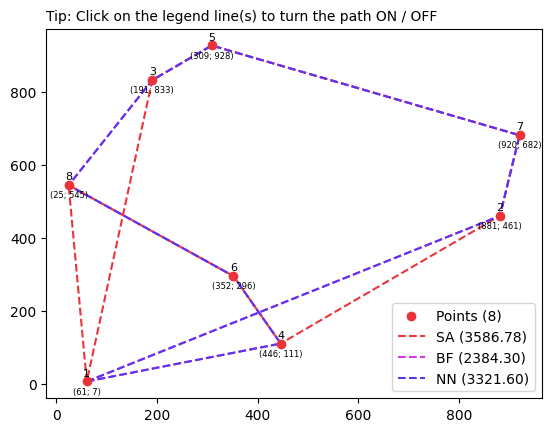

SA time: 0.041548967361450195
NN time: 0.00010609626770019531


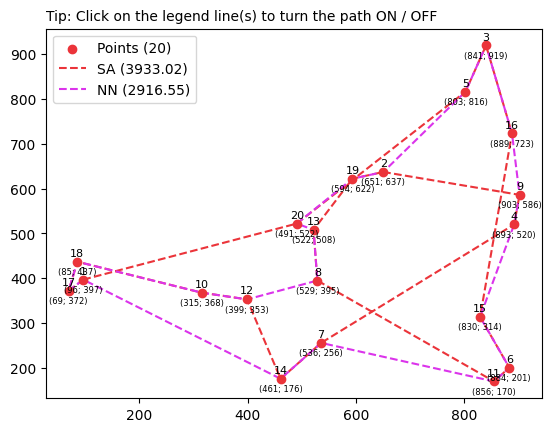

SA time: 0.10536074638366699
NN time: 0.001981973648071289


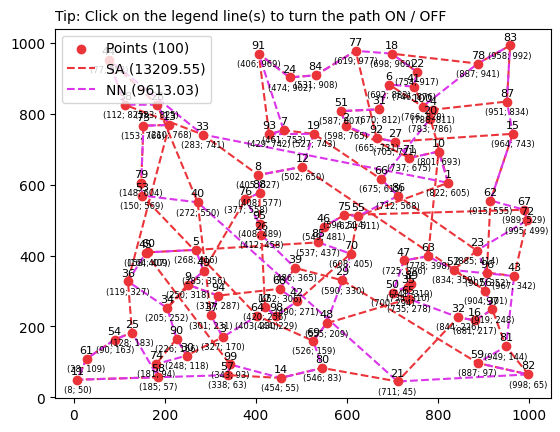

In [28]:
# Usage Examples

from time import time
import matplotlib.pyplot as plt

def small() -> None:

    points = generate_problem(8)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")


    ts = time()
    bf = BF()
    paths.append(bf.run(points=points, name="BF"))
    print(f"BF time: {time()-ts}")

    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def medium():
    points = generate_problem(20)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")


    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def large():
    points = generate_problem(100)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")
    
    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def main() -> None:
    """Tests performance of algorithms."""

    small()
    medium()
    large()


if __name__ == "__main__":
    main()

In [29]:
import time
import matplotlib.pyplot as plt
import pandas as pd

class SAWithConvergence(SA):
    def run_with_convergence(self, points: list[tuple[int]], name: str = None):
        """Runs the algorithm for the given 2D points with convergence tracking."""
        l = len(points)
        dm = SA._distance_matrix(points)
        tmp_indx = [i for i in range(l)] + [0]
        tmp_leng = SA._calculate_dist(dm, tmp_indx)
        res_indx = tmp_indx.copy()
        res_leng = tmp_leng
        
        convergence_data = []
        
        for iteration in range(self.iter):
            i, j = sample(range(1, l), 2)
            prb_indx = tmp_indx.copy()
            prb_indx[i], prb_indx[j] = prb_indx[j], prb_indx[i]
            prb_leng = SA._calculate_dist(dm, prb_indx)
            
            if self.is_acceptable(prb_leng, tmp_leng):
                tmp_indx = prb_indx
                tmp_leng = prb_leng
                
            if tmp_leng < res_leng:
                res_indx = tmp_indx
                res_leng = tmp_leng
            
            convergence_data.append({
                'iteration': iteration,
                'current_length': tmp_leng,
                'best_length': res_leng,
                'temperature': self.t
            })
            
            self.t *= self.g
            
        return Path(indx=res_indx, leng=res_leng, name=name), convergence_data

BF time: 0.019930, length: 2460.62
NN time: 0.000029, length: 3331.93
SA time: 0.001978, length: 3401.68


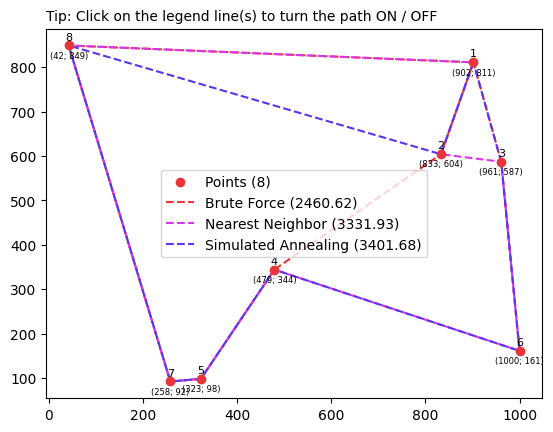

NN time: 0.000118, length: 4324.33
SA time: 0.012197, length: 4592.52


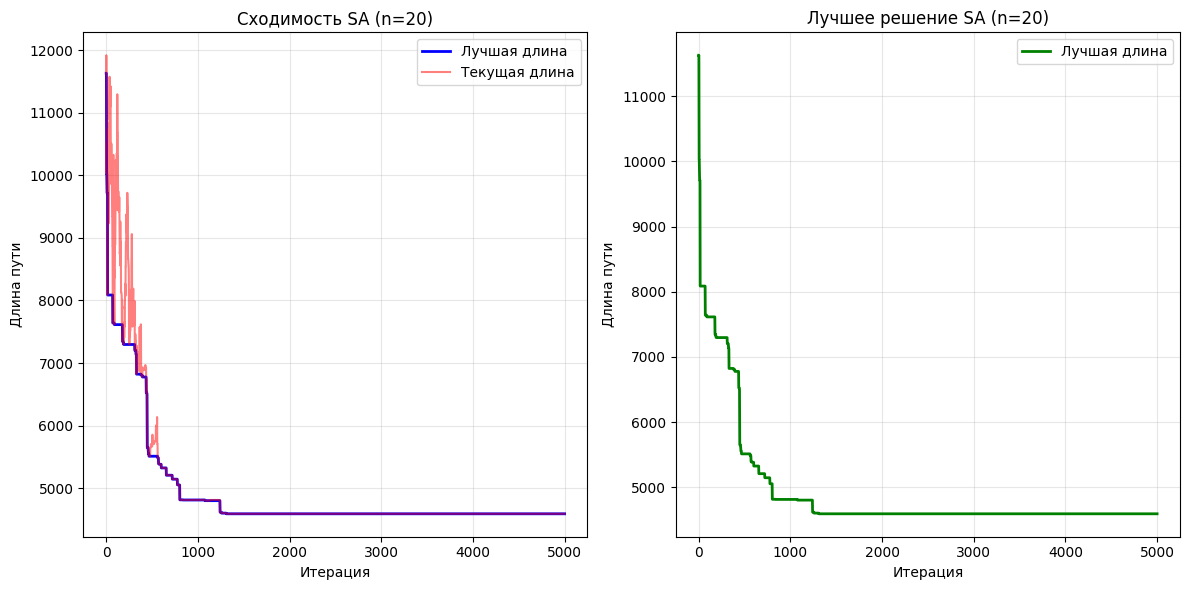

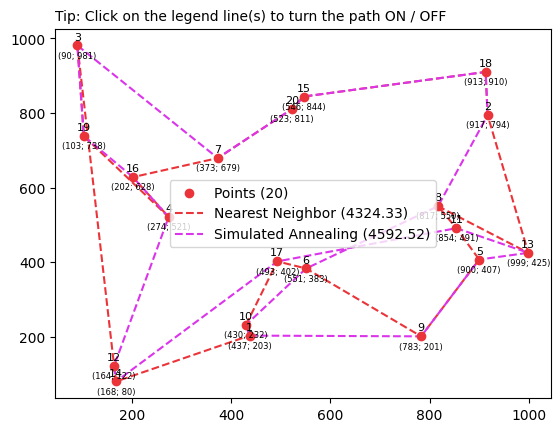

NN time: 0.001932, length: 9720.01
SA time: 0.056289, length: 15742.68

Сводная таблица результатов:
Размер задачи  NN время (с)    NN длина  SA время (с)     SA длина BF время (с)     BF длина
          n=8      0.000029 3331.929856      0.001978  3401.680234      0.01993  2460.623933
         n=20      0.000118 4324.333805      0.012197  4592.517109            -            -
        n=100      0.001932 9720.009879      0.056289 15742.679381            -            -


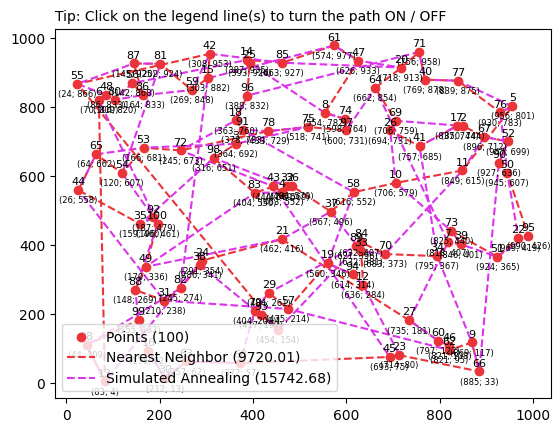

In [30]:
if __name__ == "__main__":
    small_points = generate_problem(8, 1000)
    
    start_time = time.time()
    bf_path = BF().run(small_points, "Brute Force")
    bf_time = time.time() - start_time
    
    start_time = time.time()
    nn_path = NN().run(small_points, "Nearest Neighbor")
    nn_time = time.time() - start_time
    
    start_time = time.time()
    sa_path = SA(iter=1000, t=1000, g=0.99).run(small_points, "Simulated Annealing")
    sa_time = time.time() - start_time
    
    print(f"BF time: {bf_time:.6f}, length: {bf_path.leng:.2f}")
    print(f"NN time: {nn_time:.6f}, length: {nn_path.leng:.2f}")
    print(f"SA time: {sa_time:.6f}, length: {sa_path.leng:.2f}")
    
    TSP(small_points, [bf_path, nn_path, sa_path])
    
    medium_points = generate_problem(20, 1000)
    
    start_time = time.time()
    nn_path_medium = NN().run(medium_points, "Nearest Neighbor")
    nn_time_medium = time.time() - start_time
    
    sa_with_conv = SAWithConvergence(iter=5000, t=1000, g=0.995)
    start_time = time.time()
    sa_path_medium, convergence_data = sa_with_conv.run_with_convergence(medium_points, "Simulated Annealing")
    sa_time_medium = time.time() - start_time
    
    print(f"NN time: {nn_time_medium:.6f}, length: {nn_path_medium.leng:.2f}")
    print(f"SA time: {sa_time_medium:.6f}, length: {sa_path_medium.leng:.2f}")
    
    iterations = [data['iteration'] for data in convergence_data]
    best_lengths = [data['best_length'] for data in convergence_data]
    current_lengths = [data['current_length'] for data in convergence_data]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(iterations, best_lengths, 'b-', label='Лучшая длина', linewidth=2)
    plt.plot(iterations, current_lengths, 'r-', alpha=0.5, label='Текущая длина')
    plt.xlabel('Итерация')
    plt.ylabel('Длина пути')
    plt.title('Сходимость SA (n=20)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(iterations, best_lengths, 'g-', label='Лучшая длина', linewidth=2)
    plt.xlabel('Итерация')
    plt.ylabel('Длина пути')
    plt.title('Лучшее решение SA (n=20)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    TSP(medium_points, [nn_path_medium, sa_path_medium])
    
    large_points = generate_problem(100, 1000)
    
    start_time = time.time()
    nn_path_large = NN().run(large_points, "Nearest Neighbor")
    nn_time_large = time.time() - start_time
    
    start_time = time.time()
    sa_path_large = SA(iter=10000, t=1000, g=0.999).run(large_points, "Simulated Annealing")
    sa_time_large = time.time() - start_time
    
    print(f"NN time: {nn_time_large:.6f}, length: {nn_path_large.leng:.2f}")
    print(f"SA time: {sa_time_large:.6f}, length: {sa_path_large.leng:.2f}")
    
    summary_data = {
        'Размер задачи': ['n=8', 'n=20', 'n=100'],
        'NN время (с)': [nn_time, nn_time_medium, nn_time_large],
        'NN длина': [nn_path.leng, nn_path_medium.leng, nn_path_large.leng],
        'SA время (с)': [sa_time, sa_time_medium, sa_time_large],
        'SA длина': [sa_path.leng, sa_path_medium.leng, sa_path_large.leng]
    }
    
    if 'bf_time' in locals():
        summary_data['BF время (с)'] = [bf_time, '-', '-']
        summary_data['BF длина'] = [bf_path.leng, '-', '-']
    
    df_summary = pd.DataFrame(summary_data)
    print("\nСводная таблица результатов:")
    print(df_summary.to_string(index=False))
    
    TSP(large_points, [nn_path_large, sa_path_large])


ИССЛЕДОВАНИЕ ДЛЯ n=100 ВЕРШИН

1. ОДНА И ТА ЖЕ МАТРИЦА РАССТОЯНИЙ (1000 прогонов)
Завершено прогонов: 100/1000
Завершено прогонов: 200/1000
Завершено прогонов: 300/1000
Завершено прогонов: 400/1000
Завершено прогонов: 500/1000
Завершено прогонов: 600/1000
Завершено прогонов: 700/1000
Завершено прогонов: 800/1000
Завершено прогонов: 900/1000
Завершено прогонов: 1000/1000

Время выполнения (одна матрица):
  Среднее: 0.056199
  Медиана: 0.055986
  Стандартное отклонение: 0.001678
  Минимум: 0.055367
  Максимум: 0.083961
  25-й перцентиль: 0.055858
  75-й перцентиль: 0.056142

Длина пути (одна матрица):
  Среднее: 15491.721355
  Медиана: 15456.901323
  Стандартное отклонение: 901.066327
  Минимум: 13339.200881
  Максимум: 18170.823228
  25-й перцентиль: 14886.103266
  75-й перцентиль: 16101.998958

2. РАЗНЫЕ МАТРИЦЫ РАССТОЯНИЙ (1000 прогонов)
Завершено прогонов: 100/1000
Завершено прогонов: 200/1000
Завершено прогонов: 300/1000
Завершено прогонов: 400/1000
Завершено прогонов: 500/1000
Зав

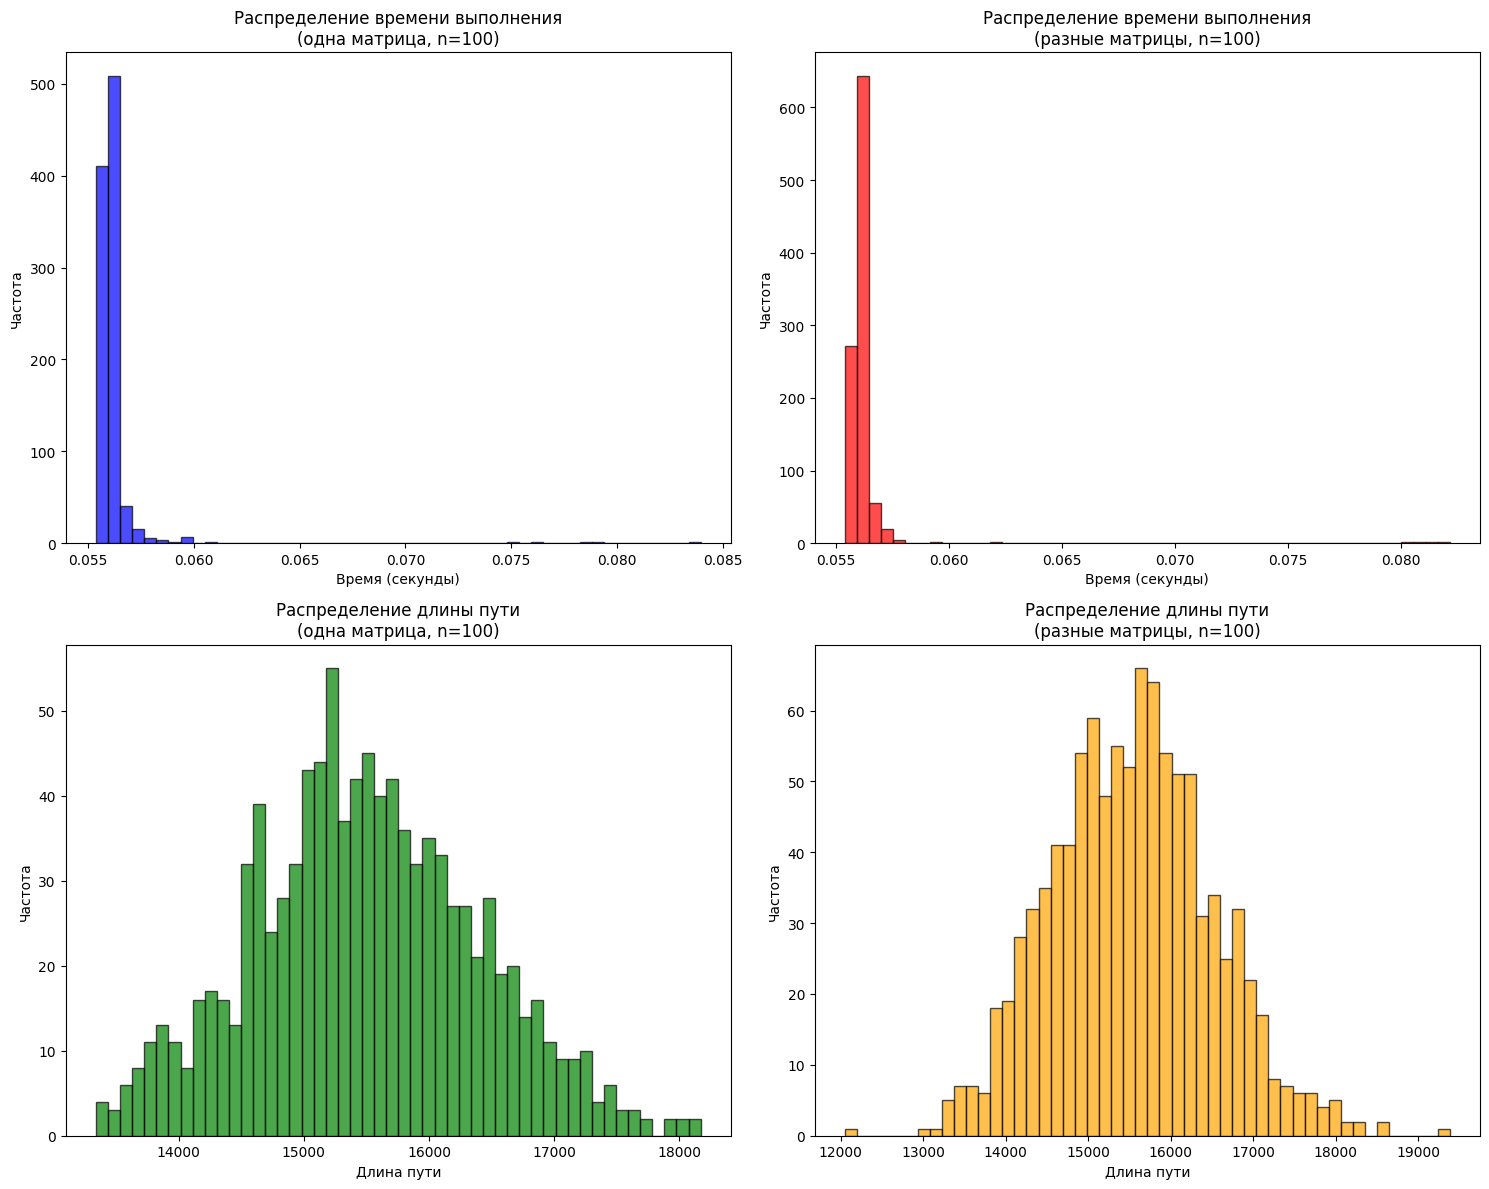

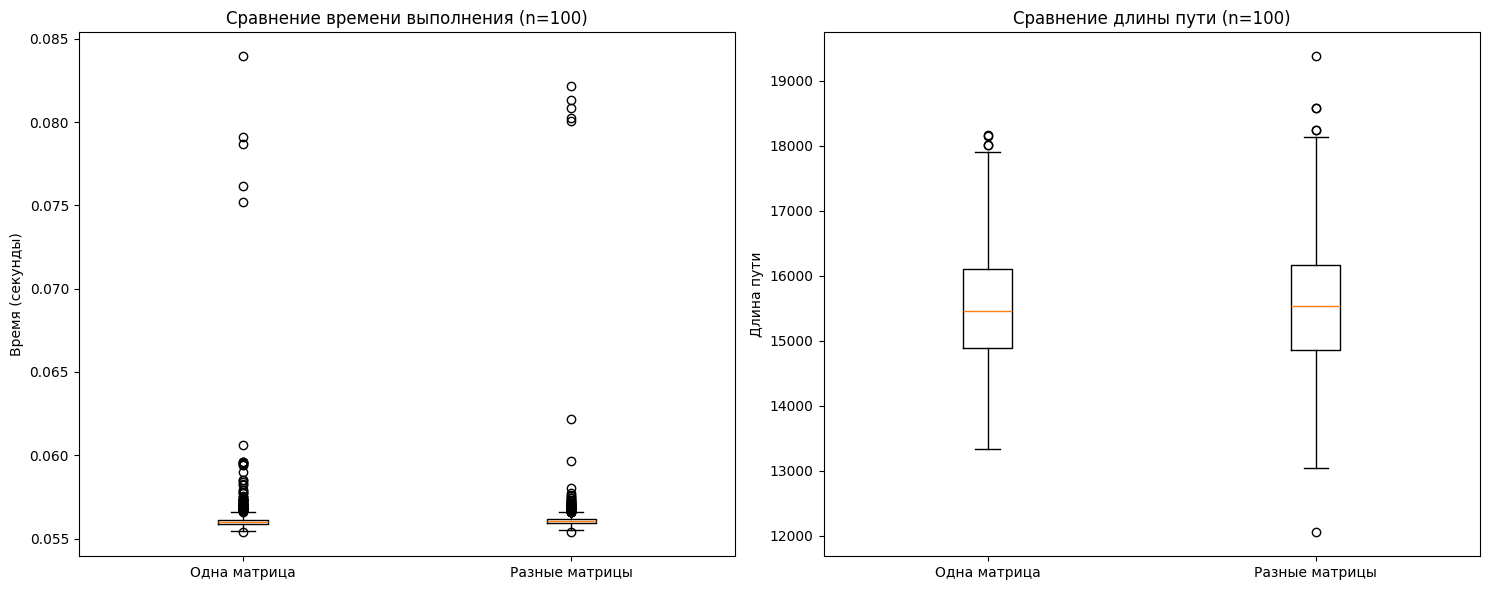


ИССЛЕДОВАНИЕ ДЛЯ n=500 ВЕРШИН

1. ОДНА И ТА ЖЕ МАТРИЦА РАССТОЯНИЙ (1000 прогонов)
Завершено прогонов: 100/1000
Завершено прогонов: 200/1000
Завершено прогонов: 300/1000
Завершено прогонов: 400/1000
Завершено прогонов: 500/1000
Завершено прогонов: 600/1000
Завершено прогонов: 700/1000
Завершено прогонов: 800/1000
Завершено прогонов: 900/1000
Завершено прогонов: 1000/1000

Время выполнения (одна матрица):
  Среднее: 0.521840
  Медиана: 0.521404
  Стандартное отклонение: 0.004142
  Минимум: 0.508841
  Максимум: 0.552799
  25-й перцентиль: 0.520601
  75-й перцентиль: 0.522237

Длина пути (одна матрица):
  Среднее: 86311.817449
  Медиана: 86269.512853
  Стандартное отклонение: 2268.946670
  Минимум: 79366.656719
  Максимум: 94819.290795
  25-й перцентиль: 84761.485971
  75-й перцентиль: 87782.564790

2. РАЗНЫЕ МАТРИЦЫ РАССТОЯНИЙ (1000 прогонов)
Завершено прогонов: 100/1000
Завершено прогонов: 200/1000
Завершено прогонов: 300/1000
Завершено прогонов: 400/1000
Завершено прогонов: 500/1000
За

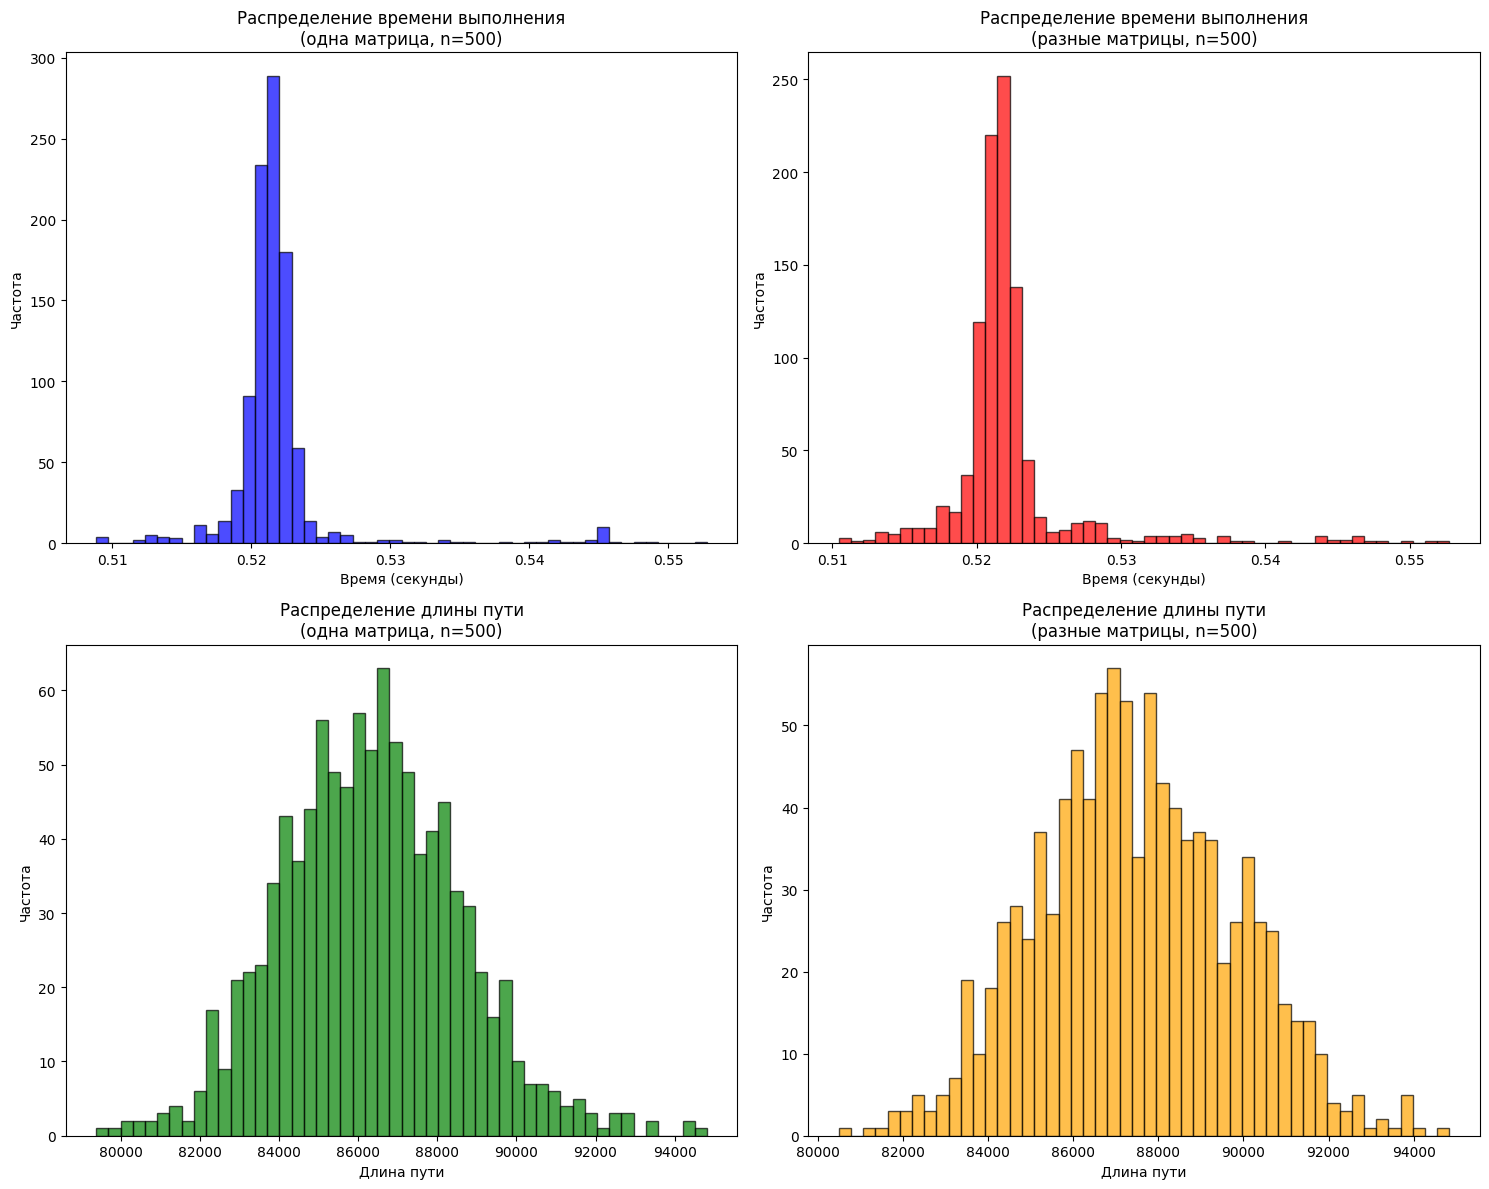

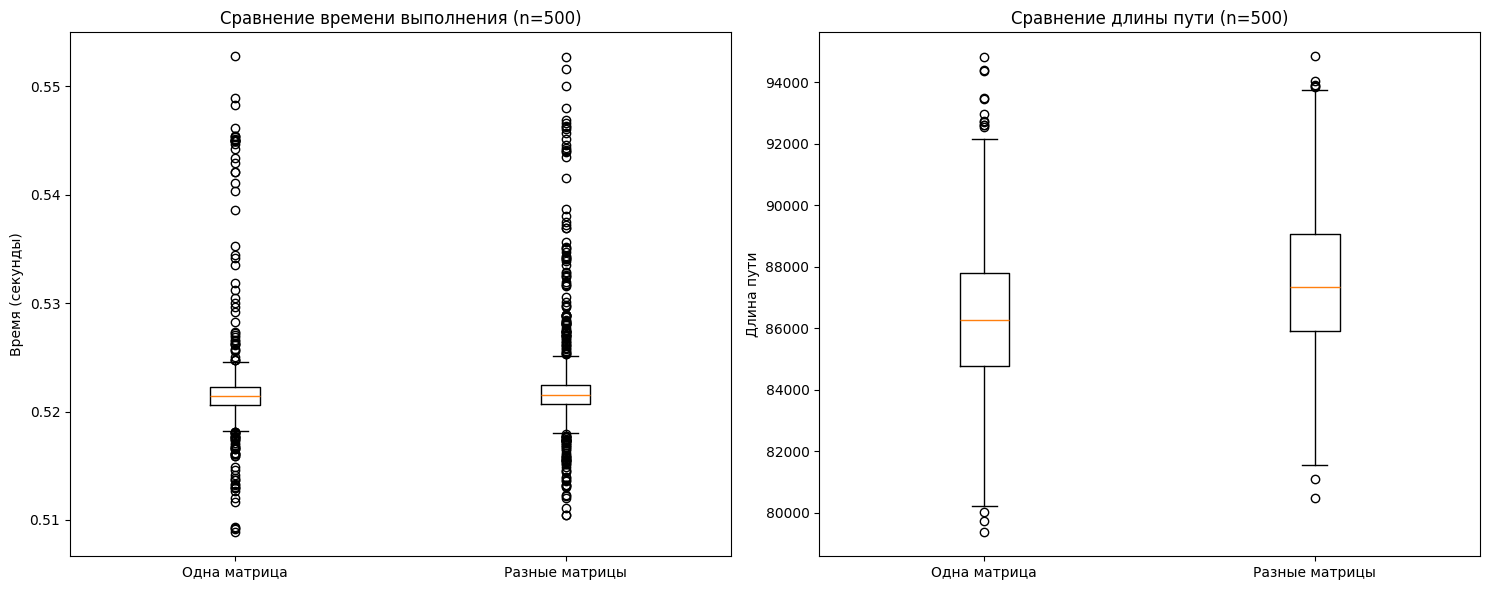


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ИССЛЕДОВАНИЯ
                    Параметр      Среднее  Стандартное отклонение      Медиана
  n=100 Время (одна матрица)     0.056199                0.001678     0.055986
n=100 Время (разные матрицы)     0.056228                0.001791     0.056048
  n=100 Длина (одна матрица) 15491.721355              901.066327 15456.901323
n=100 Длина (разные матрицы) 15533.517653              974.117347 15540.571775
  n=500 Время (одна матрица)     0.521840                0.004142     0.521404
n=500 Время (разные матрицы)     0.522241                0.004539     0.521565
  n=500 Длина (одна матрица) 86311.817449             2268.946670 86269.512853
n=500 Длина (разные матрицы) 87466.796609             2324.119739 87332.791031

АНАЛИЗ КОРРЕЛЯЦИИ
Корреляция время-длина (n=100, одна матрица): 0.010162
Корреляция время-длина (n=100, разные матрицы): 0.003410
Корреляция время-длина (n=500, одна матрица): -0.006743
Корреляция время-длина (n=500, разные матрицы): 0.020498


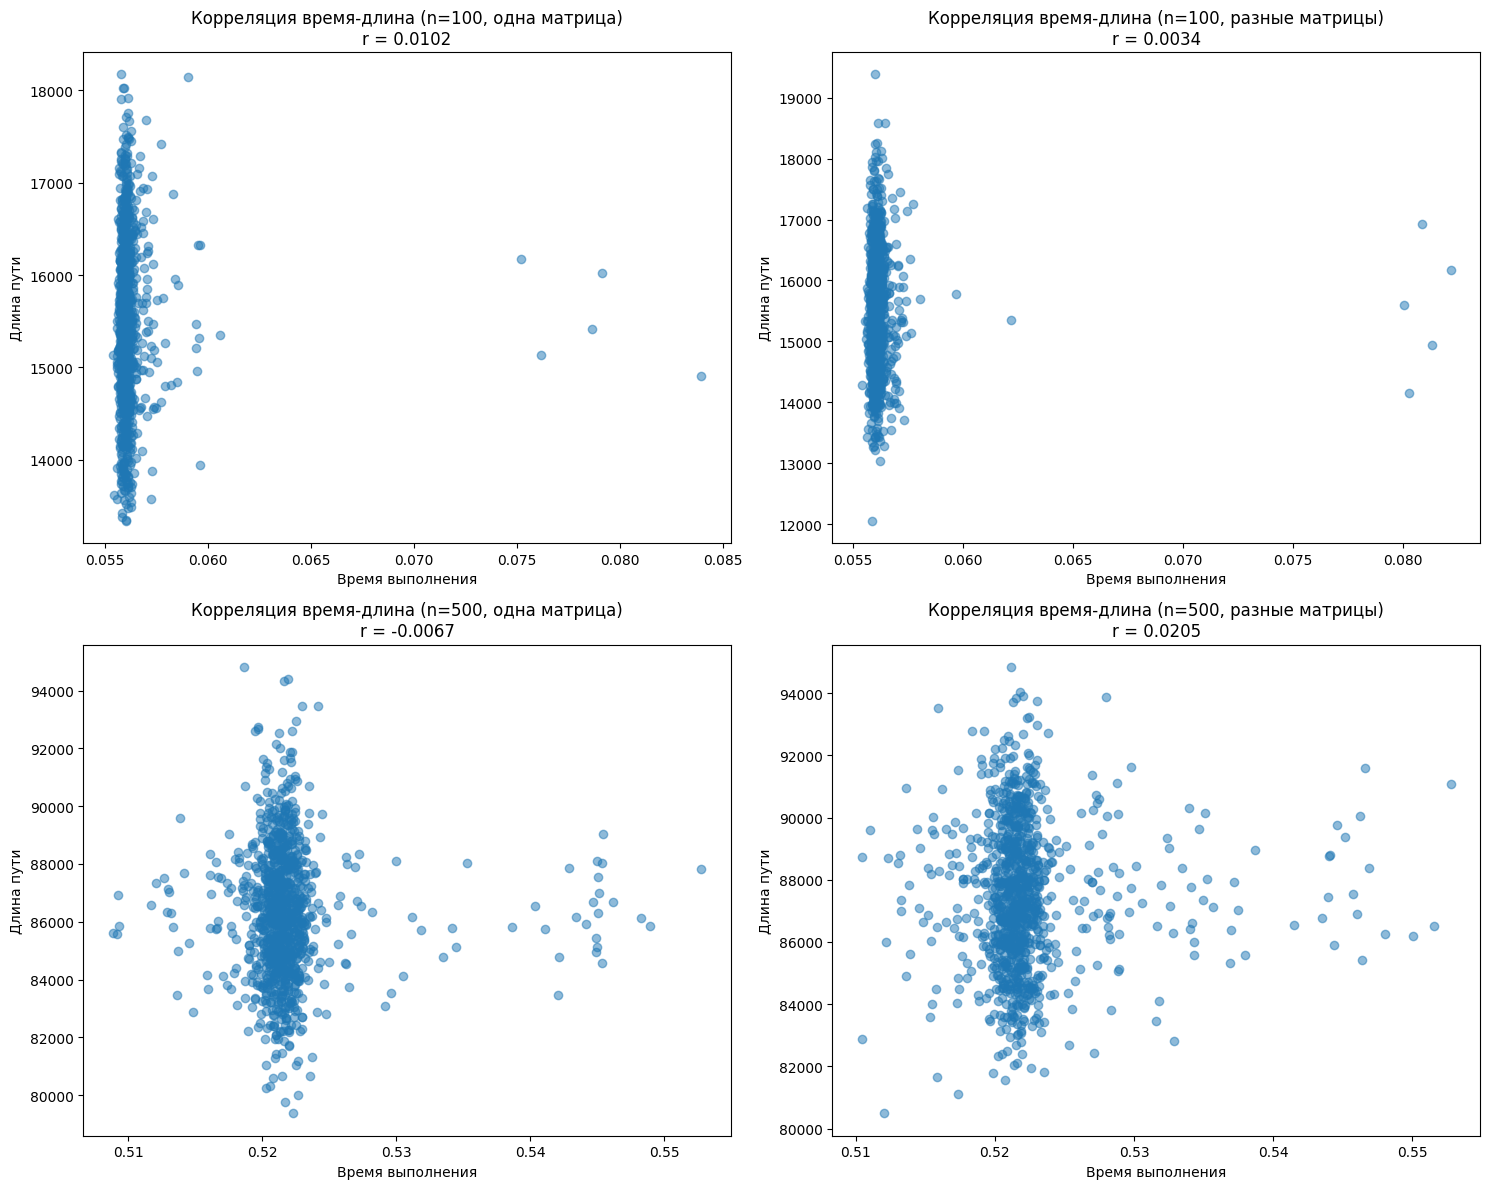

In [31]:
import numpy as np
from scipy import stats
import seaborn as sns


def run_sa_experiment(points, n_runs=1000, iter=10000, t=1000, g=0.999):
    """Запускает SA алгоритм multiple раз и собирает статистику"""
    iterations_data = []
    time_data = []
    length_data = []
    
    for run in range(n_runs):
        start_time = time.time()
        sa = SA(iter=iter, t=t, g=g)
        path = sa.run(points, f"SA Run {run+1}")
        end_time = time.time()
        
        iterations_data.append(iter)
        time_data.append(end_time - start_time)
        length_data.append(path.leng)
        
        if (run + 1) % 100 == 0:
            print(f"Завершено прогонов: {run + 1}/{n_runs}")
    
    return iterations_data, time_data, length_data

def run_sa_different_matrices(n_points, n_runs=1000, iter=10000, t=1000, g=0.999, canvas_size=1000):
    """Запускает SA алгоритм на разных матрицах расстояний"""
    iterations_data = []
    time_data = []
    length_data = []
    
    for run in range(n_runs):
        points = generate_problem(n_points, canvas_size)
        
        start_time = time.time()
        sa = SA(iter=iter, t=t, g=g)
        path = sa.run(points, f"SA Matrix Run {run+1}")
        end_time = time.time()
        
        iterations_data.append(iter)
        time_data.append(end_time - start_time)
        length_data.append(path.leng)
        
        if (run + 1) % 100 == 0:
            print(f"Завершено прогонов: {run + 1}/{n_runs}")
    
    return iterations_data, time_data, length_data

def analyze_distribution(data, title):
    """Анализирует распределение данных и выводит статистику"""
    data_array = np.array(data)
    
    print(f"\n{title}:")
    print(f"  Среднее: {np.mean(data_array):.6f}")
    print(f"  Медиана: {np.median(data_array):.6f}")
    print(f"  Стандартное отклонение: {np.std(data_array):.6f}")
    print(f"  Минимум: {np.min(data_array):.6f}")
    print(f"  Максимум: {np.max(data_array):.6f}")
    print(f"  25-й перцентиль: {np.percentile(data_array, 25):.6f}")
    print(f"  75-й перцентиль: {np.percentile(data_array, 75):.6f}")
    
    return data_array

print("\n" + "="*60)
print("ИССЛЕДОВАНИЕ ДЛЯ n=100 ВЕРШИН")
print("="*60)

print("\n1. ОДНА И ТА ЖЕ МАТРИЦА РАССТОЯНИЙ (1000 прогонов)")
points_100 = generate_problem(100, 1000)
iterations_same_100, time_same_100, length_same_100 = run_sa_experiment(
    points_100, n_runs=1000, iter=10000, t=1000, g=0.999
)

time_same_100_array = analyze_distribution(time_same_100, "Время выполнения (одна матрица)")
length_same_100_array = analyze_distribution(length_same_100, "Длина пути (одна матрица)")

print("\n2. РАЗНЫЕ МАТРИЦЫ РАССТОЯНИЙ (1000 прогонов)")
iterations_diff_100, time_diff_100, length_diff_100 = run_sa_different_matrices(
    100, n_runs=1000, iter=10000, t=1000, g=0.999
)

time_diff_100_array = analyze_distribution(time_diff_100, "Время выполнения (разные матрицы)")
length_diff_100_array = analyze_distribution(length_diff_100, "Длина пути (разные матрицы)")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(time_same_100_array, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение времени выполнения\n(одна матрица, n=100)')
axes[0, 0].set_xlabel('Время (секунды)')
axes[0, 0].set_ylabel('Частота')

axes[0, 1].hist(time_diff_100_array, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 1].set_title('Распределение времени выполнения\n(разные матрицы, n=100)')
axes[0, 1].set_xlabel('Время (секунды)')
axes[0, 1].set_ylabel('Частота')

axes[1, 0].hist(length_same_100_array, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_title('Распределение длины пути\n(одна матрица, n=100)')
axes[1, 0].set_xlabel('Длина пути')
axes[1, 0].set_ylabel('Частота')

axes[1, 1].hist(length_diff_100_array, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Распределение длины пути\n(разные матрицы, n=100)')
axes[1, 1].set_xlabel('Длина пути')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

time_data_100 = [time_same_100_array, time_diff_100_array]
axes[0].boxplot(time_data_100, tick_labels=['Одна матрица', 'Разные матрицы'])
axes[0].set_title('Сравнение времени выполнения (n=100)')
axes[0].set_ylabel('Время (секунды)')

length_data_100 = [length_same_100_array, length_diff_100_array]
axes[1].boxplot(length_data_100, tick_labels=['Одна матрица', 'Разные матрицы'])
axes[1].set_title('Сравнение длины пути (n=100)')
axes[1].set_ylabel('Длина пути')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ИССЛЕДОВАНИЕ ДЛЯ n=500 ВЕРШИН")
print("="*60)

print("\n1. ОДНА И ТА ЖЕ МАТРИЦА РАССТОЯНИЙ (1000 прогонов)")
points_500 = generate_problem(500, 1000)
iterations_same_500, time_same_500, length_same_500 = run_sa_experiment(
    points_500, n_runs=1000, iter=20000, t=1000, g=0.9995
)

time_same_500_array = analyze_distribution(time_same_500, "Время выполнения (одна матрица)")
length_same_500_array = analyze_distribution(length_same_500, "Длина пути (одна матрица)")

print("\n2. РАЗНЫЕ МАТРИЦЫ РАССТОЯНИЙ (1000 прогонов)")
iterations_diff_500, time_diff_500, length_diff_500 = run_sa_different_matrices(
    500, n_runs=1000, iter=20000, t=1000, g=0.9995
)

time_diff_500_array = analyze_distribution(time_diff_500, "Время выполнения (разные матрицы)")
length_diff_500_array = analyze_distribution(length_diff_500, "Длина пути (разные матрицы)")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(time_same_500_array, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение времени выполнения\n(одна матрица, n=500)')
axes[0, 0].set_xlabel('Время (секунды)')
axes[0, 0].set_ylabel('Частота')

axes[0, 1].hist(time_diff_500_array, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 1].set_title('Распределение времени выполнения\n(разные матрицы, n=500)')
axes[0, 1].set_xlabel('Время (секунды)')
axes[0, 1].set_ylabel('Частота')

axes[1, 0].hist(length_same_500_array, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_title('Распределение длины пути\n(одна матрица, n=500)')
axes[1, 0].set_xlabel('Длина пути')
axes[1, 0].set_ylabel('Частота')

axes[1, 1].hist(length_diff_500_array, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Распределение длины пути\n(разные матрицы, n=500)')
axes[1, 1].set_xlabel('Длина пути')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

time_data_500 = [time_same_500_array, time_diff_500_array]
axes[0].boxplot(time_data_500, tick_labels=['Одна матрица', 'Разные матрицы'])
axes[0].set_title('Сравнение времени выполнения (n=500)')
axes[0].set_ylabel('Время (секунды)')

length_data_500 = [length_same_500_array, length_diff_500_array]
axes[1].boxplot(length_data_500, tick_labels=['Одна матрица', 'Разные матрицы'])
axes[1].set_title('Сравнение длины пути (n=500)')
axes[1].set_ylabel('Длина пути')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ИССЛЕДОВАНИЯ")
print("="*80)

summary_data = {
    'Параметр': [
        'n=100 Время (одна матрица)', 'n=100 Время (разные матрицы)',
        'n=100 Длина (одна матрица)', 'n=100 Длина (разные матрицы)',
        'n=500 Время (одна матрица)', 'n=500 Время (разные матрицы)',
        'n=500 Длина (одна матрица)', 'n=500 Длина (разные матрицы)'
    ],
    'Среднее': [
        np.mean(time_same_100_array), np.mean(time_diff_100_array),
        np.mean(length_same_100_array), np.mean(length_diff_100_array),
        np.mean(time_same_500_array), np.mean(time_diff_500_array),
        np.mean(length_same_500_array), np.mean(length_diff_500_array)
    ],
    'Стандартное отклонение': [
        np.std(time_same_100_array), np.std(time_diff_100_array),
        np.std(length_same_100_array), np.std(length_diff_100_array),
        np.std(time_same_500_array), np.std(time_diff_500_array),
        np.std(length_same_500_array), np.std(length_diff_500_array)
    ],
    'Медиана': [
        np.median(time_same_100_array), np.median(time_diff_100_array),
        np.median(length_same_100_array), np.median(length_diff_100_array),
        np.median(time_same_500_array), np.median(time_diff_500_array),
        np.median(length_same_500_array), np.median(length_diff_500_array)
    ]
}

df_summary_detailed = pd.DataFrame(summary_data)
print(df_summary_detailed.to_string(index=False, float_format='%.6f'))

print("\n" + "="*60)
print("АНАЛИЗ КОРРЕЛЯЦИИ")
print("="*60)

corr_time_length_100_same = np.corrcoef(time_same_100_array, length_same_100_array)[0, 1]
corr_time_length_100_diff = np.corrcoef(time_diff_100_array, length_diff_100_array)[0, 1]

corr_time_length_500_same = np.corrcoef(time_same_500_array, length_same_500_array)[0, 1]
corr_time_length_500_diff = np.corrcoef(time_diff_500_array, length_diff_500_array)[0, 1]

print(f"Корреляция время-длина (n=100, одна матрица): {corr_time_length_100_same:.6f}")
print(f"Корреляция время-длина (n=100, разные матрицы): {corr_time_length_100_diff:.6f}")
print(f"Корреляция время-длина (n=500, одна матрица): {corr_time_length_500_same:.6f}")
print(f"Корреляция время-длина (n=500, разные матрицы): {corr_time_length_500_diff:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(time_same_100_array, length_same_100_array, alpha=0.5)
axes[0, 0].set_title(f'Корреляция время-длина (n=100, одна матрица)\nr = {corr_time_length_100_same:.4f}')
axes[0, 0].set_xlabel('Время выполнения')
axes[0, 0].set_ylabel('Длина пути')

axes[0, 1].scatter(time_diff_100_array, length_diff_100_array, alpha=0.5)
axes[0, 1].set_title(f'Корреляция время-длина (n=100, разные матрицы)\nr = {corr_time_length_100_diff:.4f}')
axes[0, 1].set_xlabel('Время выполнения')
axes[0, 1].set_ylabel('Длина пути')

axes[1, 0].scatter(time_same_500_array, length_same_500_array, alpha=0.5)
axes[1, 0].set_title(f'Корреляция время-длина (n=500, одна матрица)\nr = {corr_time_length_500_same:.4f}')
axes[1, 0].set_xlabel('Время выполнения')
axes[1, 0].set_ylabel('Длина пути')

axes[1, 1].scatter(time_diff_500_array, length_diff_500_array, alpha=0.5)
axes[1, 1].set_title(f'Корреляция время-длина (n=500, разные матрицы)\nr = {corr_time_length_500_diff:.4f}')
axes[1, 1].set_xlabel('Время выполнения')
axes[1, 1].set_ylabel('Длина пути')

plt.tight_layout()
plt.show()